<a href="https://colab.research.google.com/github/gregoryshermantheoriginal/GERG/blob/main/LPD_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialise libraries

In [1]:
#Download Pytorch Geometric

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [2]:
#Import the libraries
import os
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils import erdos_renyi_graph, to_networkx, from_networkx

import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import combinations, groupby
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from scipy.ndimage.filters import gaussian_filter1d
from collections import namedtuple

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

import sklearn
import torch.nn.utils.prune as prune
from tqdm import tqdm


#Data Preparation

In [3]:
#Set seed 
np.random.seed(1234)

#Generate a random NetworkX graph
def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

    #Reference [1]: https://stackoverflow.com/questions/61958360/how-to-create-random-graph-where-each-node-has-at-least-1-edge-using-networkx

In [4]:
np.random.seed(1234)

#Create 200 graphs with 5 nodes
for i in range(1, 200):
  j = 0
  # j = j/10
  k = random.randint(1,42)
  globals()['G_'+str(i)] = gnp_random_connected_graph(5, j) 

In [5]:
#Define node attributes
#Randomise x and y coordinates for each of the 5 nodes
np.random.seed(1234)


for i in range(1,200):

  x_cord_0 =  random.randint(50,60)
  x_cord_1 = random.randint(45,50)
  x_cord_2 = random.randint(40,50)
  x_cord_3 = random.randint(10,20)
  x_cord_4 = random.randint(10,20)
  
  y_cord_0 = random.randint(60,70)
  y_cord_1 = random.randint(40,50)
  y_cord_2 = random.randint(50,60)
  y_cord_3 = random.randint(60,70)
  y_cord_4 = random.randint(45,50)

#Set node attributes
  pos_x={0:x_cord_0, 1:x_cord_1, 2 :x_cord_2, 3 :x_cord_3, 4:x_cord_4}
  pos_y= {0:y_cord_0, 1:y_cord_1, 2 :y_cord_2, 3 :y_cord_3, 4:y_cord_4}
  nx.set_node_attributes(globals()['G_'+str(i)], pos_x, 'pos_x')
  nx.set_node_attributes(globals()['G_'+str(i)], pos_y, 'pos_y')

In [6]:
#Visualise a graph
def viz(G):
  fig, ax = plt.subplots(figsize = (15,8))
  initialpos = {0:(nx.get_node_attributes(G, "pos_x")[0], nx.get_node_attributes(G, "pos_y")[0]), 1:(nx.get_node_attributes(G, "pos_x")[1], nx.get_node_attributes(G, "pos_y")[1]), 
                2:(nx.get_node_attributes(G, "pos_x")[2], nx.get_node_attributes(G, "pos_y")[2]), 3:(nx.get_node_attributes(G, "pos_x")[3], nx.get_node_attributes(G, "pos_y")[3]), 
                4:(nx.get_node_attributes(G, "pos_x")[4], nx.get_node_attributes(G, "pos_y")[4])}
  nx.draw(G, with_labels = True, pos = initialpos)
  limits=plt.axis('on') # turns on axis
  ax.set_xlim(0,120)
  ax.set_ylim(0,120)
  ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

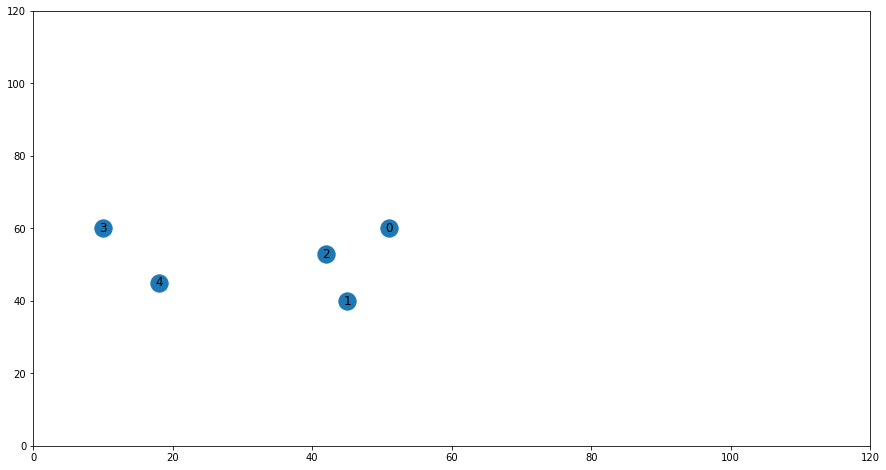

In [7]:
#Visualise graph
viz(G_1)

##MAST formulation

In [8]:
#Adding connections based on the smallest distance(area) between nodes
list_1 = [0,1,2,3,4]
list_2 = [0,1,2,3,4]

def graph_dataset(G): 
  edge_1 = []
  edge_2 = []
  distance = []
  for u in list_1:
    for v in list_2:
      df = pd.DataFrame(columns = ['edge_1','edge_2', 'distance'])
      if(u!=v):
        dist = round((((nx.get_node_attributes(G, 'pos_x')[u]  - nx.get_node_attributes(G, 'pos_x')[v])**2 + (nx.get_node_attributes(G, 'pos_y')[u] - nx.get_node_attributes(G, 'pos_y')[v])**2)**0.5),2)
        # x = random.randint(0, 5)
        # dist = x + dist
        edge_1.append(u)
        edge_2.append(v)
        distance.append(dist)
        
  df['edge_1'] = edge_1
  df['edge_2'] = edge_2
  df['distance'] = distance
  df.drop(df[ (df['edge_1'] == 0) & (df['edge_2'] == 2)].index, inplace = True)
  df.drop(df[ (df['edge_1'] == 0) & (df['edge_2'] == 3)].index, inplace = True)
  df.drop(df[ (df['edge_1'] == 0) & (df['edge_2'] == 4)].index, inplace = True)
  indexes = df[ (df['edge_1'] == 1) & (df['edge_2'] == 0)].index
  df.drop(indexes, inplace = True)
  indexes = df[ (df['edge_1'] == 1) & (df['edge_2'] == 3)].index
  df.drop(indexes, inplace = True)
  indexes = df[ (df['edge_1'] == 1) & (df['edge_2'] == 4)].index
  df.drop(indexes, inplace = True)
  indexes = df[ (df['edge_1'] == 2) & (df['edge_2'] == 0)].index
  df.drop(indexes, inplace = True)
  # indexes = df[ (df['edge_1'] == 2) & (df['edge_2'] == 3) ].index
  # df.drop(indexes, inplace = True)
  # df.drop(df[ (df['edge_1'] == 2) & (df['edge_2'] == 4)].index, inplace = True)
  df.drop(df[ (df['edge_1'] == 2) & (df['edge_2'] == 1)].index, inplace = True)

  df.sort_values(by = ['distance'], inplace = True)

  min_df = pd.DataFrame() 
  for i in df.edge_1.unique():
    globals()['df_'+str(i)] = df[df['edge_1'] == i]
    globals()['df_'+str(i)] = globals()['df_'+str(i)][globals()['df_'+str(i)].distance == globals()['df_'+str(i)].distance.min()]
    min_df = min_df.append(globals()['df_'+str(i)], ignore_index = True)
  
  return min_df


In [9]:
#Iterate the MAST function over the 200 graphs
for i in range(1,200):
  globals()['min_df_'+str(i)] = graph_dataset(globals()['G_'+str(i)])
  globals()['min_df_'+str(i)].sort_values( by = ['edge_1'], inplace = True)
  globals()['min_df_'+str(i)].reset_index (inplace = True)
  globals()['min_df_'+str(i)].drop(columns = ['index'], inplace = True)
 
  



In [10]:
#Further MAST formulation
#Ensuring that the constraint is met, i.e. node x and node y can only be connected if and only if, coverage area of node x & coverage area of node y > distance between x and y
for i in range(1, 200):
    if((globals()['min_df_'+str(i)].iloc[0,0] == 0) & (globals()['min_df_'+str(i)].iloc[0,1] == 1)):
      if(globals()['min_df_'+str(i)].iloc[0,2]>globals()['min_df_'+str(i)].iloc[1,2]): #0,1
        globals()['min_df_'+str(i)].iloc[1,2] = globals()['min_df_'+str(i)].iloc[0,2]
      else:
        globals()['min_df_'+str(i)].iloc[0,2] = globals()['min_df_'+str(i)].iloc[1,2]
    if((globals()['min_df_'+str(i)].iloc[2,0] == 2) & (globals()['min_df_'+str(i)].iloc[2,1] == 3)): #2,3
      if(globals()['min_df_'+str(i)].iloc[2,2]>globals()['min_df_'+str(i)].iloc[3,2]):
        globals()['min_df_'+str(i)].iloc[3,2] = globals()['min_df_'+str(i)].iloc[2,2]
      else:
        globals()['min_df_'+str(i)].iloc[2,2] = globals()['min_df_'+str(i)].iloc[3,2]
    if((globals()['min_df_'+str(i)].iloc[2,0] == 2) & (globals()['min_df_'+str(i)].iloc[2,1] == 4)): #2,4
      if(globals()['min_df_'+str(i)].iloc[2,2]>globals()['min_df_'+str(i)].iloc[4,2]):
        globals()['min_df_'+str(i)].iloc[4,2] = globals()['min_df_'+str(i)].iloc[2,2]
      else:
        globals()['min_df_'+str(i)].iloc[2,2] =globals()['min_df_'+str(i)].iloc[4,2]
  
    
  
 


In [11]:
#Set coverage area as a node attribute for the nodes
for i in range(1,200):
  pow={}
  pow={0:globals()['min_df_'+str(i)]['distance'][0], 1:globals()['min_df_'+str(i)]['distance'][1], 2:globals()['min_df_'+str(i)]['distance'][2], 3:globals()['min_df_'+str(i)]['distance'][3], 4:globals()['min_df_'+str(i)]['distance'][4]}
  nx.set_node_attributes(globals()['G_'+str(i)], pow, 'y')
  

In [12]:
#Adding edges where the constraint is met, i.e. edge exist between a pair of nodes if and only if their individual coverage area is greater than the distance between the pair of nodes
for i in range(1,200):
  globals()['G_'+str(i)].add_edge(0, 1)
  cov_0 = nx.get_node_attributes(globals()['G_'+str(i)], 'y')[0]
  cov_1 = nx.get_node_attributes(globals()['G_'+str(i)], 'y')[1]
  cov_2 = nx.get_node_attributes(globals()['G_'+str(i)], 'y')[2]
  cov_3 = nx.get_node_attributes(globals()['G_'+str(i)], 'y')[3]
  cov_4 = nx.get_node_attributes(globals()['G_'+str(i)], 'y')[4]
  dist_12 = round((((nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[1]  - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[2])**2 + (nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[1] - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[2])**2)**0.5),2)
  dist_23 = round((((nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[2]  - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[3])**2 + (nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[2] - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[3])**2)**0.5),2)
  dist_24 = round((((nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[2]  - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[4])**2 + (nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[2] - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[4])**2)**0.5),2)
  dist_34 = round((((nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[3]  - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[4])**2 + (nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[3] - nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[4])**2)**0.5),2)
  if((cov_1 >= dist_12) & (cov_2 >= dist_12)):
    globals()['G_'+str(i)].add_edge(1, 2)
  if((cov_2>=dist_23) & (cov_3>=dist_23)):
    globals()['G_'+str(i)].add_edge(2, 3)  
  if((cov_2>=dist_24) & (cov_4>=dist_24)):
    globals()['G_'+str(i)].add_edge(2, 4)  
  if((cov_3>=dist_34) & (cov_4>=dist_34)):
    globals()['G_'+str(i)].add_edge(3, 4)  

##Converting NetworkX graph to Pytorch Geometric Objects

In [13]:
#Appeding all the graphs to an empty list
Graphs = []
for i in range(1, 200):
  Graphs.append(globals()['G_'+str(i)])

In [14]:
#Convert to PyG objects with features as node coordinates
for i in range(1,199):
  globals()['data_'+str(i)] = from_networkx(Graphs[i],['pos_x','pos_y'])

In [15]:
#List of data for dataloader
data_list = [data_1,	data_2,	data_3,	data_4,	data_5,	data_6,	data_7,	data_8,	data_9,	data_10,	data_11,	data_12,	data_13,	data_14,	data_15,	data_16,	data_17,	data_18,	data_19,	data_20,	data_21,	data_22,	data_23,	data_24,	data_25,	data_26,	data_27,	data_28,	data_29,	data_30,	data_31,	data_32,	data_33,	data_34,	data_35,	data_36,	data_37,	data_38,	data_39,	data_40,	data_41,	data_42,	data_43,	data_44,	data_45,	data_46,	data_47,	data_48,	data_49,	data_50,	data_51,	data_52,	data_53,	data_54,	data_55,	data_56,	data_57,	data_58,	data_59,	data_60,	data_61,	data_62,	data_63,	data_64,	data_65,	data_66,	data_67,	data_68,	data_69,	data_70,	data_71,	data_72,	data_73,	data_74,	data_75,	data_76,	data_77,	data_78,	data_79,	data_80,	data_81,	data_82,	data_83,	data_84,	data_85,	data_86,	data_87,	data_88,	data_89,	data_90,	data_91,	data_92,	data_93,	data_94,	data_95,	data_96,	data_97,	data_98,	data_99,	data_100,	data_101,	data_102,	data_103,	data_104,	data_105,	data_106,	data_107,	data_108,	data_109,	data_110,	data_111,	data_112,	data_113,	data_114,	data_115,	data_116,	data_117,	data_118,	data_119,	data_120,	data_121,	data_122,	data_123,	data_124,	data_125,	data_126,	data_127,	data_128,	data_129,	data_130,	data_131,	data_132,	data_133,	data_134,	data_135,	data_136,	data_137,	data_138,	data_139,	data_140,	data_141,	data_142,	data_143,	data_144,	data_145,	data_146,	data_147,	data_148,	data_149,	data_150,	data_151,	data_152,	data_153,	data_154,	data_155,	data_156,	data_157,	data_158,	data_159,	data_160,	data_161,	data_162,	data_163,	data_164,	data_165,	data_166,	data_167,	data_168,	data_169,	data_170,	data_171,	data_172,	data_173,	data_174,	data_175,	data_176,	data_177,	data_178,	data_179,	data_180,	data_181,	data_182,	data_183,	data_184,	data_185,	data_186,	data_187,	data_188,	data_189,	data_190,	data_191,	data_192,	data_193,	data_194,	data_195,	data_196,	data_197,	data_198]

In [16]:
#Split data into train and test
train_data = data_list[0:190]

test_data = data_list[190:]

In [17]:
#Prepare data before feeding into our GCN 
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#GCN

##Define model

In [18]:
#GCN Architecture
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        
        self.linear2 = torch.nn.Linear(2, 512)
        self.conv2 = GCNConv(512,256)
        self.conv3 = GCNConv(256,128)

        self.conv4 = GCNConv(128,64)

        
        
        self.linear1 = torch.nn.Linear(64,1)
        #self.linear3 = torch.nn.Linear(32,1)
    def forward(self, x, edge_index):
       
        x = self.linear2(x)
        x = x.relu()
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = x.relu()

               
        x = self.conv3(x, edge_index)
        x = x.relu()
        
        x = self.conv4(x, edge_index)
        x = x.relu()
        

        x = self.linear1(x)
        x = x.relu()

        


        
               
        return x

In [19]:
#Initialise our GCN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(512).to(device)

In [20]:
#Define optimiser
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
#Model architecture
print(model)

GCN(
  (linear2): Linear(in_features=2, out_features=512, bias=True)
  (conv2): GCNConv(512, 256)
  (conv3): GCNConv(256, 128)
  (conv4): GCNConv(128, 64)
  (linear1): Linear(in_features=64, out_features=1, bias=True)
)


##Train our model

In [22]:
#Train our model and evaluate on the test set
train_pred = []
train_values = []
val_pred = []
val_values = []
for e in range(1000):
    print(e)
    model.train()     # Optional when not using Model Specific layer
    for data in train_loader:

      optim.zero_grad()
      data.x = data.x.to(device, dtype = torch.float)
      data.y = data.y.to(device, dtype = torch.float)

      pred = model(data.x, data.edge_index)
      
      loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
      pred_np = pred.detach().numpy()
      data.y_np = data.y.detach().numpy() 
      train_pred.append(pred_np)
      train_values.append(data.y_np)
      loss.backward()
      optim.step()
    
    model.eval()
    for data in test_loader:
           # Optional when not using Model Specific layer
      optim.zero_grad()
      data.x = data.x.to(device, dtype = torch.float)
      data.y = data.y.to(device, dtype = torch.float)
      
      pred = model(data.x, data.edge_index)
      
      loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
      pred_np = pred.detach().numpy()
      data.y_np = data.y.detach().numpy() 
      val_pred.append(pred_np)
      val_values.append(data.y_np)
      print(loss)
        

0
tensor(45.1658, grad_fn=<MseLossBackward0>)
1
tensor(32.0682, grad_fn=<MseLossBackward0>)
2
tensor(45.7550, grad_fn=<MseLossBackward0>)
3
tensor(35.6354, grad_fn=<MseLossBackward0>)
4
tensor(37.6803, grad_fn=<MseLossBackward0>)
5
tensor(38.9692, grad_fn=<MseLossBackward0>)
6
tensor(32.4871, grad_fn=<MseLossBackward0>)
7
tensor(38.2033, grad_fn=<MseLossBackward0>)
8
tensor(34.4604, grad_fn=<MseLossBackward0>)
9
tensor(35.5760, grad_fn=<MseLossBackward0>)
10
tensor(35.5194, grad_fn=<MseLossBackward0>)
11
tensor(33.9318, grad_fn=<MseLossBackward0>)
12
tensor(36.3178, grad_fn=<MseLossBackward0>)
13
tensor(32.4887, grad_fn=<MseLossBackward0>)
14
tensor(36.4865, grad_fn=<MseLossBackward0>)
15
tensor(31.4074, grad_fn=<MseLossBackward0>)
16
tensor(33.4000, grad_fn=<MseLossBackward0>)
17
tensor(34.7904, grad_fn=<MseLossBackward0>)
18
tensor(30.8821, grad_fn=<MseLossBackward0>)
19
tensor(34.0807, grad_fn=<MseLossBackward0>)
20
tensor(30.8335, grad_fn=<MseLossBackward0>)
21
tensor(30.7628, grad

##Visualise learning curves

In [ ]:
#Obtain the training/validation curves
def train_graph(pred, train, val_pred, val_train, epochs):

  median_scores_train = []
  median_scores_test = []

  mean_scores_train = []
  mean_scores_test = []

  for i in range(1,epochs):
    median_scores_train.append(median_absolute_error(pred[i], train[i]))
    mean_scores_train.append(mean_absolute_error(pred[i], train[i]))
    median_scores_test.append(median_absolute_error(val_pred[i], val_train[i]))
    mean_scores_test.append(mean_absolute_error(val_pred[i], val_train[i]))

  epoch = []
  for i in range(1,epochs):
    epoch.append(i)

  ysmoothed_median_train = gaussian_filter1d(median_scores_train, sigma=2)
  ysmoothed_mean_train = gaussian_filter1d(mean_scores_train, sigma=2)

  ysmoothed_median_test = gaussian_filter1d(median_scores_test, sigma=2)
  ysmoothed_mean_test = gaussian_filter1d(mean_scores_test, sigma=2)

  plt.rcParams['figure.figsize'] = [7, 7]
  plt.plot(epoch, ysmoothed_median_train, label = 'Train Median Absolute error')
  plt.plot(epoch, ysmoothed_mean_train, label = 'Train Mean Absolute error')

  plt.plot(epoch, ysmoothed_median_test, label = 'Test Median Absolute error')
  plt.plot(epoch, ysmoothed_mean_test, label = 'Test Mean Absolute error')

  listOf_Xticks = np.arange(0, epochs, epochs/10)
  plt.xticks(listOf_Xticks)

  plt.ylim([0, 12])
  plt.xlabel("Epochs")
  plt.ylabel("Error")
  plt.title("Median/Mean absolute error vs Epochs(GCN)")
  plt.legend()
  plt.show()
  print("Mimimum test median absolute error", min(median_scores_test))
  print("Mimimum test mean absolute error", min(mean_scores_test))

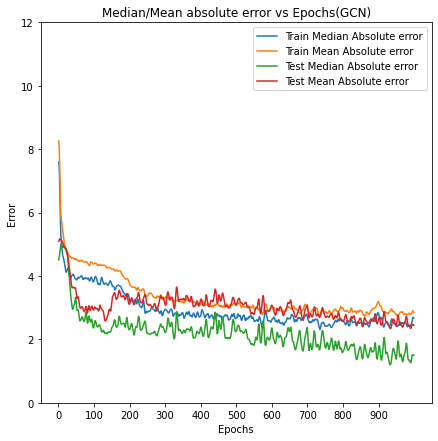

Mimimum test median absolute error 1.0637054
Mimimum test mean absolute error 2.1767857


In [24]:
#Learning curves for the GCN
train_graph(train_pred, train_values, val_pred, val_values, 1000)

##Test Evaluation

In [25]:
val_pred = []
val_values = []
for data in test_loader:
           # Optional when not using Model Specific layer
      data.x = data.x.to(device, dtype = torch.float)
      data.y = data.y.to(device, dtype = torch.float)
      
      pred = model(data.x, data.edge_index)
      
      loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
      pred_np = pred.detach().numpy()
      data.y_np = data.y.detach().numpy() 
      val_pred.append(pred_np)
      val_values.append(data.y_np)

In [26]:
val_pred = np.array(val_pred)
val_values = np.array(val_values)

In [27]:
median_absolute_error(val_pred.flatten(), val_values.flatten())

1.5182743

In [28]:
mean_absolute_error(val_pred.flatten(), val_values.flatten())

2.4276462

#Data preparation(CNN and MLP)

In [29]:
#Creating our dataset
for i in range(1,50):
  globals()['min_df_'+str(i)] = graph_dataset(globals()['G_'+str(i)])
  globals()['min_df_'+str(i)]
  for index, row in globals()['min_df_'+str(i)].iterrows():
    globals()['G_'+str(i)].add_edge(row['edge_1'], row['edge_2'])

  globals()['min_df_'+str(i)].sort_values( by = ['edge_1'], inplace = True) 
  globals()['min_df_'+str(i)]['distance'] = globals()['min_df_'+str(i)]['distance'].astype(int)
  pow={0:globals()['min_df_'+str(i)].iloc[0, 2], 1:globals()['min_df_'+str(i)].iloc[1, 2], 2:globals()['min_df_'+str(i)].iloc[2, 2], 3:globals()['min_df_'+str(i)].iloc[3, 2], 4:globals()['min_df_'+str(i)].iloc[4, 2]}
  nx.set_node_attributes(globals()['G_'+str(i)], pow, 'y')
  



In [30]:
#Data preparation
Graph = []
coord_x = []
coord_y = []
coord_near_x = []
coord_near_y = []
distance = []
for i in range(1, 200):
    for index, row in globals()['min_df_'+str(i)].iterrows():
      Graph.append(i)
      coord_x.append(nx.get_node_attributes(globals()['G_'+str(i)], 'pos_x')[row['edge_1']])
      
      coord_y.append(nx.get_node_attributes(globals()['G_'+str(i)], 'pos_y')[row['edge_1']])

      distance.append(row['distance'])

In [31]:
#Assigning values in the dataset
combined_data = pd.DataFrame(columns = ['Graph', 'coord_x', 'coord_y', 'distance'])
combined_data['Graph'] = Graph
combined_data['coord_x'] = coord_x
combined_data['coord_y'] = coord_y
combined_data['distance'] = distance


In [32]:
#Look at the first few rows of our dataset
combined_data

,Graph,coord_x,coord_y,distance
0,1,51,60,20.00
1,1,45,40,13.00
2,1,42,53,25.00
3,1,10,60,17.00
4,1,18,45,17.00
...,...,...,...,...
991,199,52,69,27.29
992,199,48,42,27.29
993,199,50,60,33.53
994,199,16,68,18.11


#MLP

##Train/Test split

In [33]:
#Splitting our training and testing data
x = combined_data[['coord_x', 'coord_y']]
y = combined_data[['distance']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.10, random_state=42, shuffle=False)

##Train model

In [34]:
#Initialise our MLP regressor
clf = MLPRegressor(random_state=20, max_iter=300).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


##Evaluate for the test set

In [35]:
#Predict on test set
pred = clf.predict(X_test)

In [36]:
#Mean absolute error for the MLP
mean_absolute_error(y_test, pred)

6.071695174861901

In [37]:
#Median absolute error for the MLP
median_absolute_error(y_test, pred)

5.514080452828173

#Convolution Neural Network

##Prepare data for our CNN

In [38]:
#Reshape values for CNN
x = x.values
x = x.reshape(x.shape[0], x.shape[1], 1)

##Train/Test split

In [39]:
#Train/Test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=42, shuffle=False)

##Define our model

In [40]:
#Define our CNN 
model = Sequential()
model.add(Conv1D(32, 2, activation="relu", input_shape=(2, 1)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))
model.compile(loss=["mae"], optimizer="adam")

In [41]:
#Model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 32)             96        
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,321
Trainable params: 4,321
Non-trainable params: 0
_________________________________________________________________


##Train CNN

In [42]:
#Train model
history = model.fit(X_train, y_train, batch_size=32,epochs=300, verbose=1, validation_data = (X_test,y_test))

Epoch 1/300
25/25 [==============================] - 1s 10ms/step - loss: 18.9552 - val_loss: 8.0024
Epoch 2/300
25/25 [==============================] - 0s 3ms/step - loss: 6.5964 - val_loss: 6.3200
Epoch 3/300
25/25 [==============================] - 0s 4ms/step - loss: 6.3203 - val_loss: 6.1248
Epoch 4/300
25/25 [==============================] - 0s 3ms/step - loss: 6.1977 - val_loss: 6.2390
Epoch 5/300
25/25 [==============================] - 0s 3ms/step - loss: 6.1758 - val_loss: 6.1781
Epoch 6/300
25/25 [==============================] - 0s 4ms/step - loss: 6.1778 - val_loss: 6.0845
Epoch 7/300
25/25 [==============================] - 0s 3ms/step - loss: 6.1326 - val_loss: 5.9063
Epoch 8/300
25/25 [==============================] - 0s 4ms/step - loss: 6.1606 - val_loss: 5.9973
Epoch 9/300
25/25 [==============================] - 0s 3ms/step - loss: 6.0813 - val_loss: 6.2451
Epoch 10/300
25/25 [==============================] - 0s 4ms/step - loss: 6.0997 - val_loss: 6.1123
Epoch 1

##Evaluate for the test set

In [43]:
#Predict for Test set
ypred = model.predict(X_test)

7/7 [==============================] - 0s 2ms/step


In [44]:
#Median absolute error for the CNN
median_absolute_error(y_test, ypred)

3.5217706298828118

In [45]:
#Nean absolute error for the CNN
mean_absolute_error(y_test, ypred)

4.724883182144165

#Federated learning with GCN

Reference[2] : https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-1-a04894f78029

##Prepare dataset for each client

In [46]:
#Create multiple train_loader for different clients
for i in range(0, 6):

  ran = random.randint(0,175)
  globals()['train_data_'+str(i)] = data_list[ran:ran+25]


In [47]:
for i in range(0,6):

  globals()['train_loader_'+str(i)] = DataLoader((globals()['train_data_'+str(i)]), batch_size=10, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


##Initialise FL parameters

In [48]:
#FL parameters
num_clients = 10
num_selected = 6
num_rounds = 150
epochs = 50
batch_size = 10

##Initialise Global model

In [49]:
#GCN Architecture
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        
        self.linear2 = torch.nn.Linear(2, 512)
        self.conv2 = GCNConv(512,256)
        self.conv3 = GCNConv(256,128)

        self.conv4 = GCNConv(128,64)

        
        
        self.linear1 = torch.nn.Linear(64,1)
        #self.linear3 = torch.nn.Linear(32,1)
    def forward(self, x, edge_index):
       
        x = self.linear2(x)
        x = x.relu()
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = x.relu()

               
        x = self.conv3(x, edge_index)
        x = x.relu()
        
        x = self.conv4(x, edge_index)
        x = x.relu()
        

        x = self.linear1(x)
        x = x.relu()

        


        
               
        return x

##Train model

In [50]:
#Train client model on client data
def client_update(client_model, optimizer, train_loader, epoch):
    """
    This function updates/trains client model on client data
    """
    model.train()
    for e in range(epoch):
        for data in train_loader:
          total_loss = 0
          opt.zero_grad()
          data.x = data.x.to(device, dtype = torch.float)
          data.y = data.y.to(device, dtype = torch.float)
          pred = model(data.x, data.edge_index)
          loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
          #total_loss += loss.item() * data.num_graphs
    
          loss.backward()
          opt.step()
    return loss.item()

In [51]:
#Fedaveraging
def server_aggregate(global_model, client_models):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
      global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
      global_model.load_state_dict(global_dict)
    for model in client_models:
      model.load_state_dict(global_model.state_dict())

In [52]:
#Define global model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = GCN(256).to(device)

In [53]:
#Define client model as an object of the global model
client_models = [ global_model for _ in range(num_selected)]

In [54]:
#Initialise weight parameters
for model in client_models:
    model.load_state_dict(global_model.state_dict())

In [55]:
#Define optimiser
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#Federated training with 6 clients and 150 rounds for each epoch
for r in range(num_rounds):
    print("Round", r)
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    loss = 0
    for i in tqdm(range(num_selected)):
        loss += client_update(client_models[i], torch.optim.Adam(model.parameters(), lr=0.001), globals()['train_data_'+str(i)], epoch=5)

Round 0


100%|██████████| 6/6 [00:03<00:00,  1.54it/s]


Round 1


100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


Round 2


100%|██████████| 6/6 [00:04<00:00,  1.21it/s]


Round 3


100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Round 4


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Round 5


100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


Round 6


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Round 7


100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


Round 8


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Round 9


100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Round 10


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Round 11


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Round 12


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Round 13


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Round 14


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


Round 15


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


Round 16


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Round 17


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Round 18


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Round 19


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Round 20


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Round 21


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Round 22


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Round 23


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Round 24


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Round 25


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Round 26


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Round 27


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Round 28


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Round 29


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Round 30


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Round 31


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Round 32


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Round 33


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


Round 34


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Round 35


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Round 36


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Round 37


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Round 38


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Round 39


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Round 40


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Round 41


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Round 42


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Round 43


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Round 44


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Round 45


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Round 46


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Round 47


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Round 48


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Round 49


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Round 50


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Round 51


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Round 52


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Round 53


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Round 54


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Round 55


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Round 56


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Round 57


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Round 58


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Round 59


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Round 60


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Round 61


100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


Round 62


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Round 63


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Round 64


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Round 65


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Round 66


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Round 67


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Round 68


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Round 69


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Round 70


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Round 71


100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Round 72


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Round 73


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Round 74


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Round 75


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Round 76


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Round 77


100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Round 78


100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Round 79


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Round 80


100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Round 81


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Round 82


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Round 83


100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Round 84


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Round 85


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


Round 86


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Round 87


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Round 88


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Round 89


100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Round 90


100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Round 91


100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Round 92


100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Round 93


100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Round 94


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Round 95


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Round 96


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


Round 97


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Round 98


100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Round 99


100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Round 100


100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Round 101


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Round 102


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Round 103


100%|██████████| 6/6 [00:08<00:00,  1.46s/it]


Round 104


100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


Round 105


100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


Round 106


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


Round 107


100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


Round 108


100%|██████████| 6/6 [00:08<00:00,  1.46s/it]


Round 109


100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Round 110


100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


Round 111


100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Round 112


100%|██████████| 6/6 [00:09<00:00,  1.59s/it]


Round 113


100%|██████████| 6/6 [00:09<00:00,  1.60s/it]


Round 114


100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Round 115


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Round 116


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Round 117


100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


Round 118


100%|██████████| 6/6 [00:10<00:00,  1.81s/it]


Round 119


100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Round 120


100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Round 121


100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


Round 122


100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Round 123


100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


Round 124


100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Round 125


100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


Round 126


100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


Round 127


100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Round 128


100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Round 129


100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Round 130


100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Round 131


100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


Round 132


100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Round 133


100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Round 134


100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


Round 135


100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


Round 136


100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Round 137


100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


Round 138


100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Round 139


100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Round 140


 50%|█████     | 3/6 [00:05<00:05,  1.81s/it]

In [ ]:
#Aggregate client state for global model
server_aggregate(global_model, client_models)

##Evaluate for GCN with federated averaging

In [ ]:
#Predict for test set using the global model
pred_ = []
test_values = []
for data in test_loader:
      data.x = data.x.to(device, dtype = torch.float)
      #data.y = data.y.to(device, dtype = torch.float)
      pred = global_model(data.x, data.edge_index)

      loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
      pred = pred.detach().numpy()
      data.y = data.y.detach().numpy() 
      
      pred_.append(pred)
      test_values.append(data.y)




In [ ]:
#Conversion
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

In [ ]:
#Median absolute error 
mae = median_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))
print(mae)

In [ ]:
#Mean absolute error 
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

mean_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))


#Pruning

#Initialise model

In [ ]:
#GCN Architecture
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        
        self.linear2 = torch.nn.Linear(2, 512)
        self.conv2 = GCNConv(512,256)
        self.conv3 = GCNConv(256,128)

        self.conv4 = GCNConv(128,64)

        
        
        self.linear1 = torch.nn.Linear(64,1)
        #self.linear3 = torch.nn.Linear(32,1)
    def forward(self, x, edge_index):
       
        x = self.linear2(x)
        x = x.relu()
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = x.relu()

               
        x = self.conv3(x, edge_index)
        x = x.relu()
        
        x = self.conv4(x, edge_index)
        x = x.relu()
        

        x = self.linear1(x)
        x = x.relu()

        


        
               
        return x

In [ ]:
#Define model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(256).to(device)

In [ ]:
#Define optimiser
optim = torch.optim.Adam(model.parameters(), lr=0.001)

#Train initial network

In [ ]:
#Train model
for epoch in range(1, 300):
  print(epoch)
  for data in train_loader:
    total_loss = 0
    optim.zero_grad()
    data.x = data.x.to(device, dtype = torch.float)
    data.y = data.y.to(device, dtype = torch.float)
    pred = model(data.x, data.edge_index)
    loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
    #total_loss += loss.item() * data.num_graphs
    
    loss.backward()
    optim.step()

#Evaluate on test set

In [ ]:
#Predict for test set
pred_ = []
test_values = []
for data in test_loader:
    data.x = data.x.to(device, dtype = torch.float)
    #data.y = data.y.to(device, dtype = torch.float)
    pred = model(data.x, data.edge_index)

    loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
    pred = pred.detach().numpy()
    data.y = data.y.detach().numpy() 
    pred_.append(pred)
    test_values.append(data.y)


In [ ]:
#Median absolute error 
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

median_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))


In [ ]:
#Mean absolute error
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

mean_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))


In [ ]:
#Save model weights
torch.save(model.state_dict(), 'model_weights_.pth')

##Magnitude-based pruning based on lowest L1 score

In [ ]:
#Reference[3]: https://pytorch.org/tutorials/intermediate/pruning_tutorial.html
#Pruning 
def prune_(proportion, GCN, layer1, layer2, layer3, layer4, layer5):
  parameters_to_prune = (
      (GCN.layer1, 'weight'),
      (GCN.layer2, 'weight'),
      (GCN.layer3, 'weight'),
      (GCN.layer4, 'weight'),
      (GCN.layer5, 'weight')
  )

  prune.global_unstructured(
      parameters_to_prune,
      pruning_method=prune.L1Unstructured,
      amount=proportion,
  )

In [ ]:
#Load model weights
model.load_state_dict(torch.load('model_weights_.pth'))

In [ ]:
#Apply pruning
prune_(0.1, model, linear2, conv2.lin, conv3.lin, conv4.lin, linear1)

###Re-train

In [ ]:
#Re-Train model
for epoch in range(1, 300):
  print(epoch)
  for data in train_loader:
    total_loss = 0
    optim.zero_grad()
    data.x = data.x.to(device, dtype = torch.float)
    data.y = data.y.to(device, dtype = torch.float)
    pred = model(data.x, data.edge_index)
    loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
    #total_loss += loss.item() * data.num_graphs
    
    loss.backward()
    optim.step()

###Evaluate on test set

In [ ]:
#Predict for test set
pred_ = []
test_values = []
for data in test_loader:
    data.x = data.x.to(device, dtype = torch.float)
    #data.y = data.y.to(device, dtype = torch.float)
    pred = model(data.x, data.edge_index)

    loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
    pred = pred.detach().numpy()
    data.y = data.y.detach().numpy() 
    pred_.append(pred)
    test_values.append(data.y)


In [ ]:
#Median absolute error 
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

median_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))


In [ ]:
#Mean absolute error
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

mean_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))


In [ ]:
#Initialise model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(2, 256)
        self.conv2 = GCNConv(256, 128)
        #self.conv3 = GCNConv(128, 1)
        #self.conv3 = GCNConv(data.num_features, 32)
        self.linear1 = torch.nn.Linear(128,1)
        # self.linear2 = torch.nn.Linear(56,1)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        # x = self.conv3(x, edge_index)
        # x = x.relu()
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        x = self.linear1(x)
        # x = x.relu()
        # x = self.linear2(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(256).to(device)

In [ ]:
#Threshold pruning
class ThresholdPruning(prune.BasePruningMethod):
    PRUNING_TYPE = "unstructured"

    def __init__(self, threshold):
        self.threshold = threshold

    def compute_mask(self, tensor, default_mask):
        return torch.abs(tensor) > self.threshold

In [ ]:
#Load previous weights
model.load_state_dict(torch.load('model_weights_.pth'))

##Magnitude-based pruning based on threshold

In [ ]:
#Reference[5]: https://stackoverflow.com/questions/61629395/how-to-prune-weights-less-than-a-threshold-in-pytorch
#Mention parameters
parameters_to_prune = (
    (model.linear2, 'weight'),
    (model.conv2.lin, 'weight'),
    (model.conv3.lin, 'weight'),
    (model.conv4.lin, 'weight'),    
    (model.linear1, 'weight')
)

prune.global_unstructured(
    parameters_to_prune, pruning_method=ThresholdPruning, threshold=0.01
)

###Re-train

In [ ]:
for epoch in range(1, 300):
  print(epoch)
  for data in train_loader:
    total_loss = 0
    optim.zero_grad()
    data.x = data.x.to(device, dtype = torch.float)
    data.y = data.y.to(device, dtype = torch.float)
    pred = model(data.x, data.edge_index)
    loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
    #total_loss += loss.item() * data.num_graphs
    
    loss.backward()
    optim.step()

###Evaluate on test set

In [ ]:
#Predict for test set
pred_ = []
test_values = []
for data in test_loader:
    data.x = data.x.to(device, dtype = torch.float)
    #data.y = data.y.to(device, dtype = torch.float)
    pred = model(data.x, data.edge_index)

    loss = F.mse_loss(pred.squeeze(), data.y.squeeze())
    pred = pred.detach().numpy()
    data.y = data.y.detach().numpy() 
    pred_.append(pred)
    test_values.append(data.y)


In [ ]:
#Median absolute error 
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

median_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))


In [ ]:
#Mean absolute error
pred_ = np.asarray(pred_)
test_values = np.asarray(test_values)

mean_absolute_error(np.ndarray.flatten(pred_), np.ndarray.flatten(test_values))
